In [7]:
import torch

# L2-A - Linear Quantization I: Quantize and De-quantize a Tensor

## Quantization with Random `Scale` and `Zero Point`

- Implement Linear Quantization for when the "scale" and the "zero point" are known/randomly selected.

In [8]:
def linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype=torch.int8):
    scaled_and_shifted_tensor = tensor/scale + zero_point # r = s(q - z) -> q = r/s + z

    rounded_tensor = torch.round(scaled_and_shifted_tensor)
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max

    q_tensor = rounded_tensor.clamp(q_min, q_max).to(dtype)

    return q_tensor

In [9]:
### a dummy tensor to test the implementation
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [10]:
# random values for scale and zero point
scale = 3.2
zero_point = -50

In [11]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, scale, zero_point)
quantized_tensor

tensor([[  10,  -54,  127],
        [ -21,   42, -108],
        [ -50,  127,   27]], dtype=torch.int8)

## Dequantization with Random `Scale` and `Zero Point`
- Now, Dequantize the tensor to see how precise the quantization is.

In [12]:
dequantized_tensor = scale*(quantized_tensor.float() - zero_point)
dequantized_tensor
# original tensor
# [[191.6, -13.5, 728.6],
#  [92.14, 295.5,  -184],
#  [0,     684.6, 245.5]]

tensor([[ 192.0000,  -12.8000,  566.4000],
        [  92.8000,  294.4000, -185.6000],
        [   0.0000,  566.4000,  246.4000]])

In [13]:
# without casting to float
dequantized_tensor = scale*(quantized_tensor - zero_point)
dequantized_tensor # some values are different due to overflow or underflow

tensor([[ 192.0000,  -12.8000, -252.8000],
        [  92.8000,  294.4000, -185.6000],
        [   0.0000, -252.8000,  246.4000]])

In [14]:
def linear_dequantization(tensor, scale, zero_point):
    return scale*(tensor.float() - zero_point)

In [15]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)
dequantized_tensor

tensor([[ 192.0000,  -12.8000,  566.4000],
        [  92.8000,  294.4000, -185.6000],
        [   0.0000,  566.4000,  246.4000]])

### Quantization Error
- Load the `plot_quantization_errors` from the helper file.
- To access the `helper.py` file, you can click `File --> Open...`, on the top left.

In [16]:
from helper import plot_quantization_errors

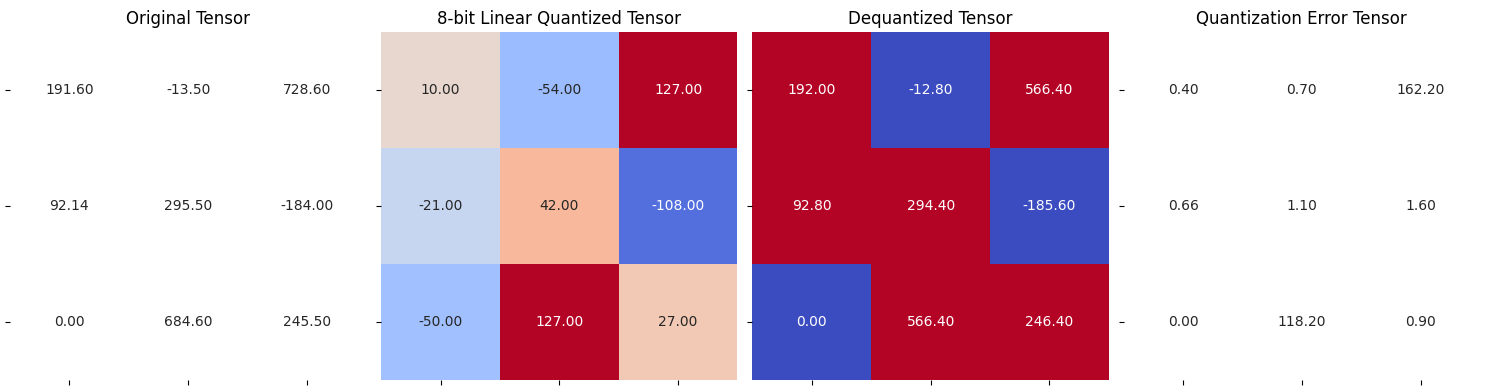

In [17]:
plot_quantization_errors(test_tensor, quantized_tensor,
                         dequantized_tensor)

**Note:** For the plot above, `Quantization Error Tensor = abs(Original Tensor - Dequantized Tensor)`

- Calculate an "overall" quantization error by using [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) technique.

In [18]:
dequantized_tensor - test_tensor

tensor([[   0.4000,    0.7000, -162.2000],
        [   0.6600,   -1.1000,   -1.6000],
        [   0.0000, -118.2000,    0.9000]])

In [19]:
(dequantized_tensor - test_tensor).square()

tensor([[1.6000e-01, 4.9000e-01, 2.6309e+04],
        [4.3560e-01, 1.2100e+00, 2.5600e+00],
        [0.0000e+00, 1.3971e+04, 8.1002e-01]])

In [20]:
(dequantized_tensor - test_tensor).square().mean()

tensor(4476.1909)

# L2-B - Linear Quantization I: Get the Scale and Zero Point

In this lesson, continue to learn about fundamentals of linear quantization, and implement your own Linear Quantizer.

## Finding `Scale` and `Zero Point` for Quantization

In [21]:
q_min = torch.iinfo(torch.int8).min
q_max = torch.iinfo(torch.int8).max
q_min, q_max

(-128, 127)

In [22]:
r_min = test_tensor.min().item()
r_max = test_tensor.max().item()
r_min, r_max

(-184.0, 728.5999755859375)

In [23]:
scale = (r_max - r_min) / (q_max - q_min)
scale

3.578823433670343

In [24]:
zero_point = q_min - (r_min / scale)
zero_point

-76.58645490333825

In [25]:
zero_point = int(round(zero_point))
zero_point

-77

Make it into a function

In [26]:
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()

    scale = (r_max - r_min) / (q_max - q_min)
    zero_point = q_min - (r_min / scale)

    # clip the zero point to fall in [quantized_min, quantized_max]
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        zero_point = int(round(zero_point))
    
    return scale, zero_point

- Test the implementation using the `test_tensor` defined earlier.
```Python
[[191.6, -13.5, 728.6],
 [92.14, 295.5,  -184],
 [0,     684.6, 245.5]]
```

In [27]:
new_scale, new_zero_point = get_q_scale_and_zero_point(test_tensor)
new_scale, new_zero_point

(3.578823433670343, -77)

## Quantization and Dequantization with Calculated `Scale` and `Zero Point`

- Use the calculated `scale` and `zero_point` with the functions `linear_q_with_scale_and_zero_point` and `linear_dequantization`.

In [28]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, new_scale, new_zero_point)
quantized_tensor

tensor([[ -23,  -81,  127],
        [ -51,    6, -128],
        [ -77,  114,   -8]], dtype=torch.int8)

In [29]:
dequantized_tensor = linear_dequantization(quantized_tensor, new_scale, new_zero_point)
dequantized_tensor

tensor([[ 193.2565,  -14.3153,  730.0800],
        [  93.0494,  297.0423, -182.5200],
        [   0.0000,  683.5552,  246.9388]])

- Plot to see how the Quantization Error looks like after using calculated `scale` and `zero_point`.

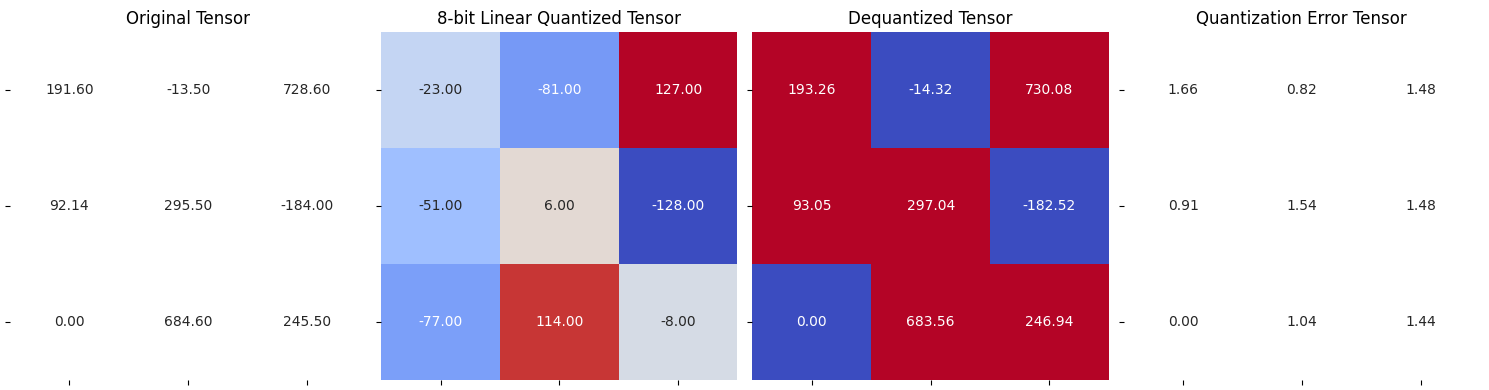

In [30]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [31]:
(dequantized_tensor-test_tensor).square().mean()

tensor(1.5730)

### Put Everything Together: Your Own Linear Quantizer

- Now, put everything togther to make your own Linear Quantizer.

In [32]:
def linear_quantization(tensor, dtype=torch.int8):
    scale, zero_point = get_q_scale_and_zero_point(tensor, dtype=dtype)
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor, scale, zero_point)

    return quantized_tensor, scale, zero_point

- Test implementation on a random matrix.

In [33]:
r_tensor = torch.randn((4,4))
r_tensor

tensor([[ 1.2862, -0.0629,  0.8072,  1.0216],
        [-0.7168,  0.3399,  0.4785,  0.9619],
        [ 0.3402,  0.0284, -1.4059, -2.2291],
        [-0.5361,  0.9593,  0.5180,  0.6821]])

In [34]:
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)

In [35]:
quantized_tensor

tensor([[ 127,   29,   93,  108],
        [ -18,   59,   69,  104],
        [  59,   36,  -68, -128],
        [  -5,  104,   72,   83]], dtype=torch.int8)

In [36]:
scale

0.013785597389819576

In [37]:
zero_point

34

In [38]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)

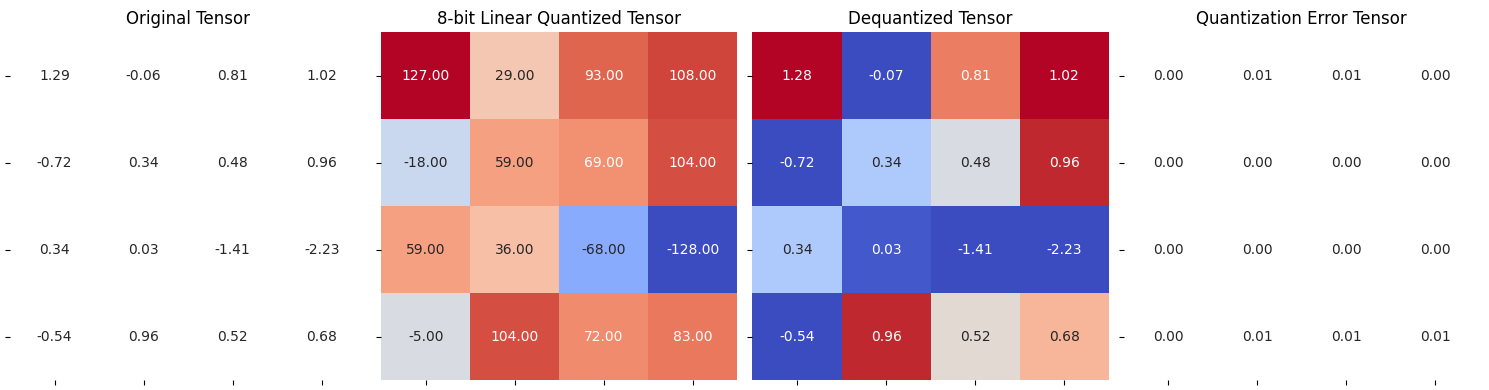

In [39]:
plot_quantization_errors(r_tensor, quantized_tensor, dequantized_tensor)

In [40]:
(dequantized_tensor - r_tensor).square().mean()

tensor(1.8248e-05)

# L3-A - Linear Quantization II: Symmetric vs. Asymmetric Mode

## Linear Quantization: Symmetric Mode
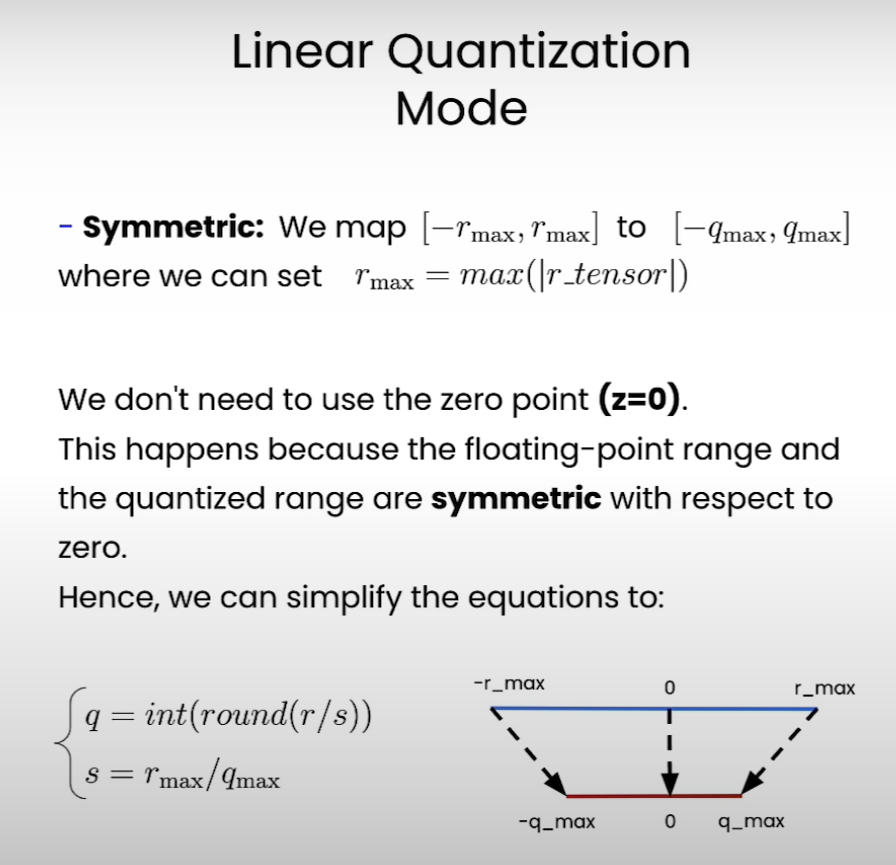
- Implement a function which returns the `scale` for Linear Quantization in Symmetric Mode.

In [41]:
def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max

    # return the scale
    return r_max/q_max

In [42]:
test_tensor = torch.randn((4,4))
test_tensor

tensor([[ 1.3057, -1.1105, -0.4576, -0.6470],
        [-0.5315,  0.1767,  0.3224, -1.3681],
        [ 1.4081,  0.1478,  0.8486,  0.4172],
        [ 0.8165,  0.3832,  0.7604, -0.7961]])

In [43]:
get_q_scale_symmetric(test_tensor)

0.011087396013455129

- Perform Linear Quantization in Symmetric Mode.


In [44]:
def linear_q_symmetric(tensor, dtype=torch.int8):
    scale = get_q_scale_symmetric(tensor)

    quantized_tensor = linear_q_with_scale_and_zero_point(tensor, scale, zero_point=0)

    return quantized_tensor, scale

In [45]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

### Dequantization

- Perform Dequantization
- Plot the Quantization error.
- `linear_dequantization` is the same function you implemented in the previous lesson.

In [46]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)

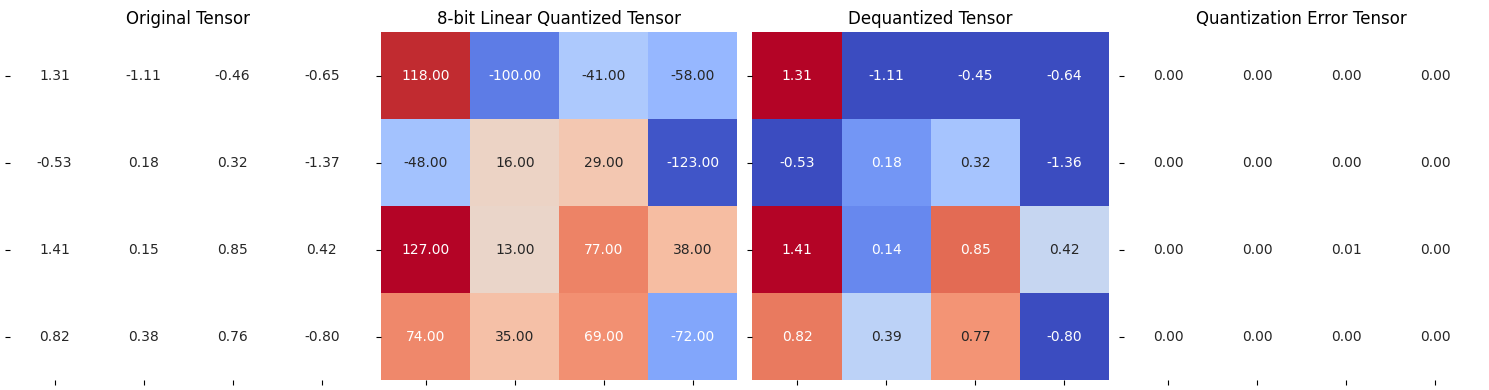

In [47]:
plot_quantization_errors(test_tensor,  quantized_tensor, dequantized_tensor)

In [48]:
print(f"Quantization error: {(test_tensor - dequantized_tensor).square().mean()}")

Quantization error: 1.1101119525847025e-05


### Linear Quantization Mode

Trade Off:
- Utilization of quantized range:
    - When using asymmetric quantization, the quantized range is fully utilized.
    - When symmetric mode, if the float range is biased towards one side, this will result in a quantized range where part of the range is dedicated to the values that we'll never see. (e.g ReLU where the output is positive)
- Simplicity: Symmetric mode is much simpler compare to asymmetric.
- Memory: We don't store zero-point for symmetric quantization

In practice we use symmetric quantization for 8 bit, but asymmetric for low precision such as 2, 3, or 4 bit.

# L3-B - Linear Quantization II: Finer Granularity for more Precision

In this lesson, you will learn about different granularities of performing linear quantization.
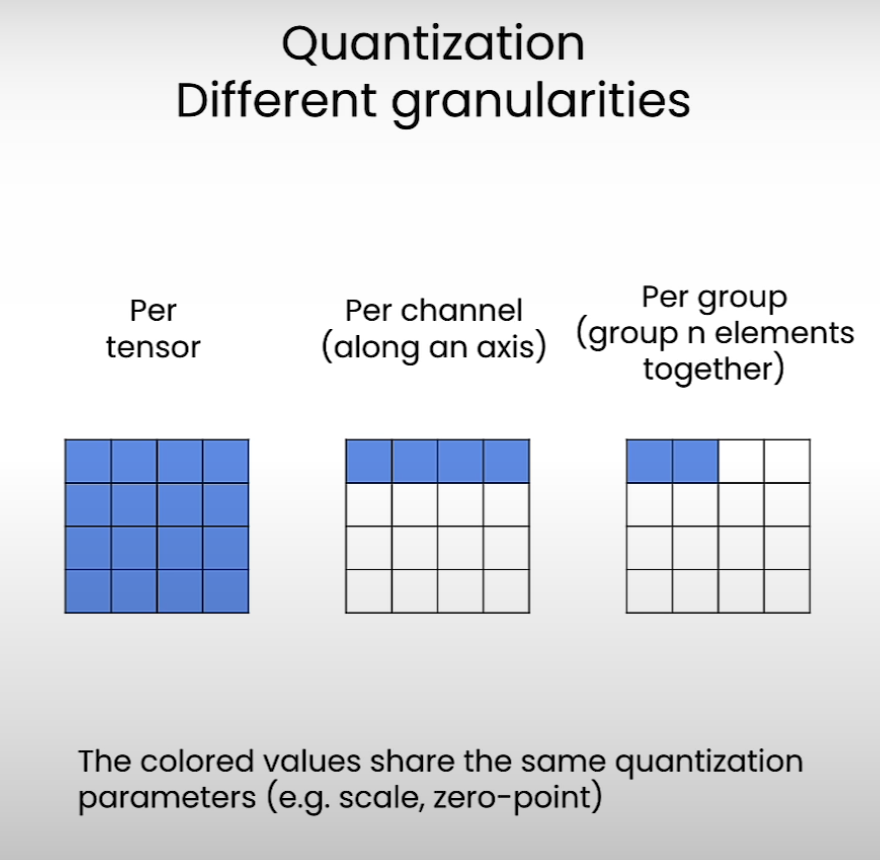

### Per Tensor
- Perform `Per Tensor` Symmetric Quantization.

In [49]:
# test tensor
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [50]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

In [51]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)

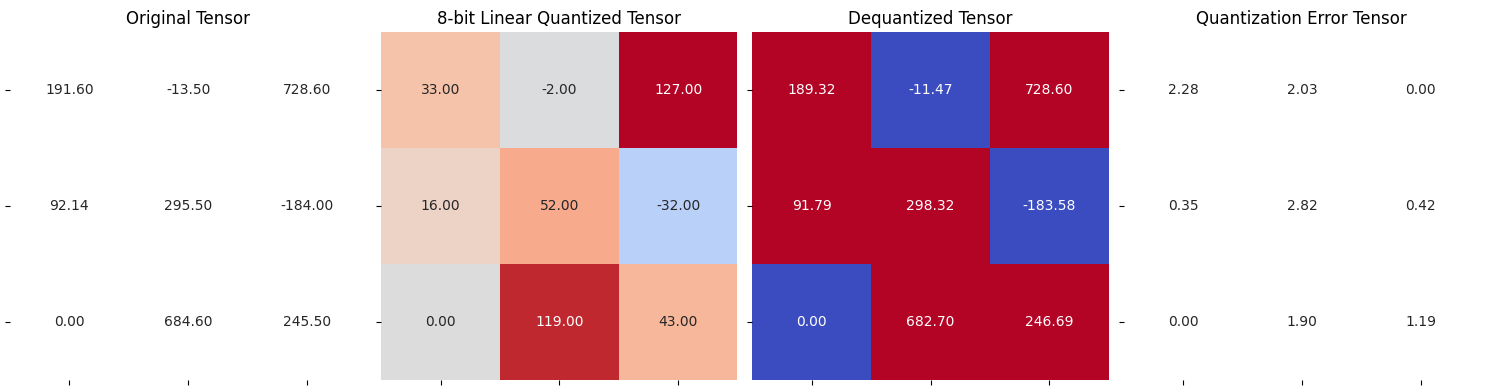

In [52]:
plot_quantization_errors(test_tensor, quantized_tensor,dequantized_tensor)

In [53]:
def quantization_error(tensor, dequantized_tensor):
    return (dequantized_tensor - tensor).abs().square().mean()

In [54]:
print(f"Quantization Error : {quantization_error(test_tensor, dequantized_tensor)}")

Quantization Error : 2.5091912746429443


# L3-C - Linear Quantization II: Per Channel Quantization

In this lesson, you will continue to learn about different granularities of performing linear quantization. You will cover `per channel`

### Per Channel
- Implement `Per Channel` Symmetric Quantization
- `dim` parameter decides if it needs to be along the rows or columns

In [55]:
def linear_q_symmetric_per_channel(tensor, dim, dtype=torch.int8):

    return quantized_tensor, scale

In [56]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

- `dim = 0`, along the rows
- `dim = 1`, along the columns

In [57]:
dim = 0
output_dim = test_tensor.shape[dim]
output_dim

3

In [58]:
scale = torch.zeros(output_dim)
scale

tensor([0., 0., 0.])

- Iterate through each row to calculate its `scale`.

In [59]:
for index in range(output_dim):
    sub_tensor = test_tensor.select(dim, index)
    # print(sub_tensor)
    scale[index] = get_q_scale_symmetric(sub_tensor)

scale

tensor([5.7370, 2.3268, 5.3906])

In [60]:
scale_shape = [1] * test_tensor.dim()
scale_shape

[1, 1]

In [61]:
scale_shape[dim] = -1
scale_shape

[-1, 1]

In [62]:
scale = scale.view(scale_shape)
copy_scale = scale
scale

tensor([[5.7370],
        [2.3268],
        [5.3906]])

#### Understanding tensor by tensor division using `view` function

In [63]:
m = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [64]:
s = torch.tensor([1,5,10])
s

tensor([ 1,  5, 10])

In [65]:
s.shape

torch.Size([3])

In [66]:
a = s.view(1, 3)
a, a.shape

(tensor([[ 1,  5, 10]]), torch.Size([1, 3]))

In [67]:
# alternate way
s.view(1, -1).shape, s.view(-1,1).shape

(torch.Size([1, 3]), torch.Size([3, 1]))

##### Along the row division

In [68]:
scale = torch.tensor([[1], [5], [10]])
m/scale

tensor([[1.0000, 2.0000, 3.0000],
        [0.8000, 1.0000, 1.2000],
        [0.7000, 0.8000, 0.9000]])

##### Along the column division

In [69]:
scale = torch.tensor([[1, 5, 10]])
m/scale

tensor([[1.0000, 0.4000, 0.3000],
        [4.0000, 1.0000, 0.6000],
        [7.0000, 1.6000, 0.9000]])

#### Coming back to quantizing the tensor

In [70]:
scale = copy_scale
scale.shape

torch.Size([3, 1])

In [71]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, scale=scale, zero_point=0)
quantized_tensor

tensor([[ 33,  -2, 127],
        [ 40, 127, -79],
        [  0, 127,  46]], dtype=torch.int8)

- Now, put all this in `linear_q_symmetric_per_channel` function defined earlier.

In [72]:
def linear_q_symmetric_per_channel(r_tensor, dim, dtype=torch.int8):
    output_dim = r_tensor.shape[dim]
    # store the scales
    scale = torch.zeros(output_dim)

    for index in range(output_dim):
        sub_tensor = r_tensor.select(dim, index)
        scale[index] = get_q_scale_symmetric(sub_tensor, dtype=dtype)
    
    # reshape the scale
    scale_shape = [1] * r_tensor.dim()
    scale_shape[dim] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_q_with_scale_and_zero_point(r_tensor, scale=scale, zero_point=0, dtype=dtype)

    return quantized_tensor, scale



In [73]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [74]:
### along the rows (dim = 0)
quantized_tensor_0, scale_0 = linear_q_symmetric_per_channel(
    test_tensor, dim=0)

### along the columns (dim = 1)
quantized_tensor_1, scale_1 = linear_q_symmetric_per_channel(
    test_tensor, dim=1)

- Plot the quantization error for along the rows.

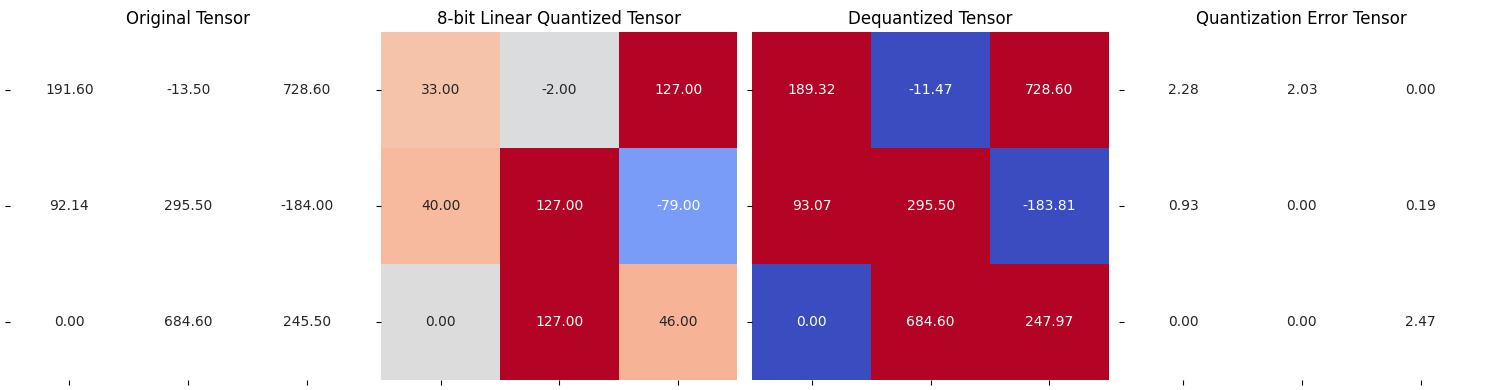

In [75]:
dequantized_tensor_0 = linear_dequantization(quantized_tensor_0, scale_0, 0)

plot_quantization_errors(test_tensor, quantized_tensor_0, dequantized_tensor_0)

In [76]:
print(f"""Quantization Error : {quantization_error(test_tensor, dequantized_tensor_0)}""")

Quantization Error : 1.8084441423416138


- Plot the quantization error for along the columns.

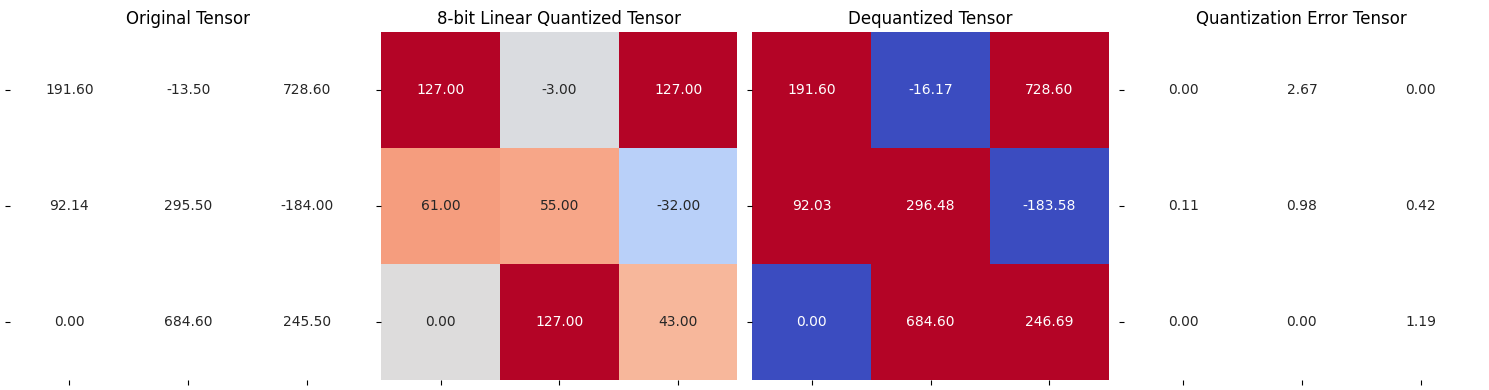

Quantization Error : 1.0781488418579102


In [77]:
dequantized_tensor_1 = linear_dequantization(
    quantized_tensor_1, scale_1, 0)

plot_quantization_errors(
    test_tensor, quantized_tensor_1, dequantized_tensor_1, n_bits=8)

print(f"""Quantization Error : \
{quantization_error(test_tensor, dequantized_tensor_1)}""")

# L3-D - Linear Quantization II: Per Group Quantization

### Per Group
- For simplicity, you'll quantize a 2D tensor along the rows.

In [78]:
def linear_q_symmetric_per_group(tensor, group_size, dtype=torch.int8):
    t_shape = tensor.shape
    assert t_shape[1] % group_size == 0
    assert tensor.dim() == 2

    tensor = tensor.view(-1, group_size)

    quantized_tensor, scale = linear_q_symmetric_per_channel(tensor, dim=0, dtype=dtype)
    quantized_tensor = quantized_tensor.view(t_shape)
    return quantized_tensor, scale


In [79]:
def linear_dequantization_per_group(quantization_tensor, scale, group_size):
    q_shape = quantization_tensor.shape
    quantization_tensor = quantization_tensor.view(-1, group_size)
    dequantized_tensor = linear_dequantization(quantization_tensor, scale, 0)
    dequantized_tensor = dequantized_tensor.view(q_shape)
    return dequantized_tensor

In [80]:
test_tensor = torch.rand((6, 6))

In [81]:
group_size = 3

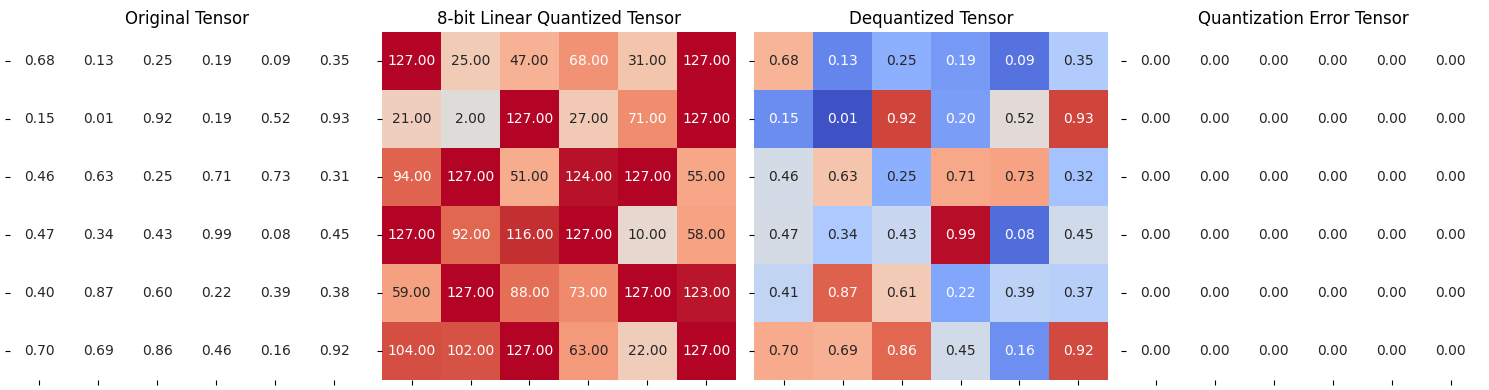

In [82]:
quantized_tensor, scale = linear_q_symmetric_per_group(test_tensor, group_size=group_size)

dequantized_tensor = linear_dequantization_per_group(quantized_tensor, scale, group_size=group_size)

plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [83]:
print(f"""Quantization Error : {quantization_error(test_tensor, dequantized_tensor)}""")

Quantization Error : 2.5029714834090555e-06


# L3-E - Linear Quantization II: Quantizing Weights & Activations for Inference

## Linear Quantization: Inference
- `W8A32` means weights in 8-bits and activations in 32-bits.
- For simplicity, the linear layer will be without bias.

In [84]:
def quantized_linear_W8A32_without_bias(input, q_w, s_w, z_w):
    assert input.dtype == torch.float32
    assert q_w.dtype == torch.int8

    # cast the weight to float32 first
    dequantized_weight = q_w.to(torch.float32) * s_w + z_w
    output = torch.nn.functional.linear(input, dequantized_weight)

    return output

In [85]:
input = torch.tensor([1, 2, 3], dtype=torch.float32)

In [86]:
weight = torch.tensor([[-2,   -1.13, 0.42],
                       [-1.51, 0.25, 1.62],
                       [0.23,  1.35, 2.15]])

In [88]:
q_w, s_w = linear_q_symmetric(weight)
q_w, s_w

(tensor([[-118,  -67,   25],
         [ -89,   15,   96],
         [  14,   80,  127]], dtype=torch.int8),
 0.016929134609192376)

In [90]:
output = quantized_linear_W8A32_without_bias(input, q_w, s_w, 0)
print(f"This is the W8A32 output: {output}")                              

This is the W8A32 output: tensor([-2.9965,  3.8768,  9.3957])


In [91]:
fp32_output = torch.nn.functional.linear(input, weight)
print(f"This is the output if we don't quantize: {fp32_output}")

This is the output if we don't quantize: tensor([-3.0000,  3.8500,  9.3800])


In [92]:
print(f"Error: {(fp32_output - output).square().mean()}")

Error: 0.0003249429864808917


# L4-A - Building your own Quantizer: Custom Build an 8-Bit Quantizer

## Step 1: class `W8A16LinearLayer`

- Build the target class, `W8A16LinearLayer()`, that will be responsible for quantizing your model.

### 1.1 - `w8_a16_forward` Function

-
```Python
W8A16LinearLayer
                    # 8-bit  # 16-bit         # optional
* w8_a16_forward -> weights, input,   scales, bias=None
                    
```
- Cast the 8-bit `weights` to the same data type as the `input`, "casted weights",
- keeping the "casted weights" in the same range as before, [-128, 127]
- Next, $$(({inputs} \cdot \text{``casted weights''}) * {scale}) + {bias}$$ 

In [93]:
import torch.nn as nn
import torch.nn.functional as F

In [94]:
random_int8 = torch.randint(-128, 127, (32, 16)).to(torch.int8) # input
random_hs = torch.randn((1, 16), dtype=torch.bfloat16) # hidden state
scales = torch.randn((1, 32), dtype=torch.bfloat16)
bias = torch.randn((1, 32), dtype=torch.bfloat16)

In [ ]:
# Typical workflow
# cast weight to same data type as hidden state and matmul using linear
F.linear(random_hs, random_int8.to(random_hs.dtype)) # outputs shape (1, 32)

tensor([[-388.0000, -342.0000,  215.0000, -832.0000, -250.0000,  -48.2500,
           42.7500, -664.0000, -137.0000,  296.0000,  496.0000,  396.0000,
          316.0000,  486.0000,  444.0000,  340.0000, -278.0000,  116.0000,
         -368.0000,  237.0000,  201.0000,  249.0000,  245.0000, -332.0000,
         -238.0000, -213.0000,   77.5000,  280.0000, -402.0000,   35.5000,
         -306.0000, -556.0000]], dtype=torch.bfloat16)

In [96]:
# multiply with scale
F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales

tensor([[-434.0000,  162.0000,   88.5000,  664.0000, -164.0000,   78.5000,
           73.0000,  792.0000,   44.5000,  -35.7500,  122.0000,  528.0000,
         -207.0000,  502.0000,  478.0000,  556.0000,  133.0000, -159.0000,
         -110.0000,  336.0000,  -53.0000,  -30.1250,   80.0000,  210.0000,
          404.0000,   13.4375,   24.2500, -576.0000,  -74.0000,   -1.0938,
          157.0000, -338.0000]], dtype=torch.bfloat16)

In [97]:
# optionally add bias
(F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales) + bias

tensor([[-4.3200e+02,  1.6200e+02,  8.7000e+01,  6.6400e+02, -1.6400e+02,
          7.7500e+01,  7.2500e+01,  7.9200e+02,  4.6000e+01, -3.7000e+01,
          1.2200e+02,  5.2800e+02, -2.0800e+02,  5.0200e+02,  4.7800e+02,
          5.5600e+02,  1.3400e+02, -1.6000e+02, -1.1050e+02,  3.3800e+02,
         -5.1250e+01, -2.9500e+01,  7.9500e+01,  2.0800e+02,  4.0400e+02,
          1.4062e+01,  2.3625e+01, -5.7600e+02, -7.2500e+01, -5.9766e-01,
          1.5700e+02, -3.3600e+02]], dtype=torch.bfloat16)

In [98]:
def w8_a16_forward(weight, input, scales, bias=None):
    
    casted_weights = weight.to(input.dtype)
    output = F.linear(input, casted_weights) * scales
    
    if bias is not None:
        output = output + bias
      
    return output

In [ ]:
print("With bias:\n\n", w8_a16_forward(random_int8, random_hs, scales, bias))

print("\nWithout bias:\n\n", w8_a16_forward(random_int8, random_hs, scales))

With bias:

 tensor([[-4.3200e+02,  1.6200e+02,  8.7000e+01,  6.6400e+02, -1.6400e+02,
          7.7500e+01,  7.2500e+01,  7.9200e+02,  4.6000e+01, -3.7000e+01,
          1.2200e+02,  5.2800e+02, -2.0800e+02,  5.0200e+02,  4.7800e+02,
          5.5600e+02,  1.3400e+02, -1.6000e+02, -1.1050e+02,  3.3800e+02,
         -5.1250e+01, -2.9500e+01,  7.9500e+01,  2.0800e+02,  4.0400e+02,
          1.4062e+01,  2.3625e+01, -5.7600e+02, -7.2500e+01, -5.9766e-01,
          1.5700e+02, -3.3600e+02]], dtype=torch.bfloat16)

Without bias:

 tensor([[-434.0000,  162.0000,   88.5000,  664.0000, -164.0000,   78.5000,
           73.0000,  792.0000,   44.5000,  -35.7500,  122.0000,  528.0000,
         -207.0000,  502.0000,  478.0000,  556.0000,  133.0000, -159.0000,
         -110.0000,  336.0000,  -53.0000,  -30.1250,   80.0000,  210.0000,
          404.0000,   13.4375,   24.2500, -576.0000,  -74.0000,   -1.0938,
          157.0000, -338.0000]], dtype=torch.bfloat16)


### 1.2 - `init` Function of class `W8A16LinearLayer`

- This is how the `init` is of [PyTorch Linear layer](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear):
```Python
def __init__(self, in_features, out_features, bias=True,
             device=None, dtype=None)

```

In [100]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, dtype=torch.float32):
        super().__init__()

        # when you create with nn.Paramter, Pytorch expects to be able to compute gradients on it,
        # but with Pytorch you can't compute int8 gradients yet
        self.int8_weights = nn.Parameter(torch.Tensor([0,1]).to(dtype=torch.int8))
try:
    
    W8A16LinearLayer(1, 1)
    
except Exception as error:
    print("\033[91m", type(error).__name__, ": ", error, "\033[0m")

 RuntimeError :  Only Tensors of floating point and complex dtype can require gradients 


In [ ]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        # with buffer, we don't need to compute gradients, so you can initialize with whatever dtype you want
        self.register_buffer("int8_weights", torch.randint(-128, 127, (out_features, in_features), dtype=torch.int8))

        self.register_buffer("scales", torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias", torch.randn((1, out_features), dtype=dtype))
        
        else:
            self.bias = None

In [102]:
dummy_instance = W8A16LinearLayer(16, 32)

In [103]:
print(dummy_instance.int8_weights.shape)
print(dummy_instance.scales.shape)

torch.Size([32, 16])
torch.Size([32])


### 1.3 - `forward` Function of class `W8A16LinearLayer`

- Use the `w8_a16_forward` defined earlier (Step 1.1) to define the `forward` function.

In [105]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        # with buffer, we don't need to compute gradients, so you can initialize with whatever dtype you want
        self.register_buffer("int8_weights",torch.randint(-128, 127, (out_features, in_features), dtype=torch.int8))

        self.register_buffer("scales", torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias", torch.randn((1, out_features), dtype=dtype))
        
        else:
            self.bias = None
    
    def forward(self, input):
        return w8_a16_forward(self.int8_weights, input, self.scales, self.bias)

In [106]:
module = W8A16LinearLayer(16, 32)
# hidden state with shape (batch_size, sequence_length, hidden shape)
dummy_hidden_states = torch.randn(1, 6, 16) 

In [ ]:
# shape (batch_size, sequence_length, output_shape)
module(dummy_hidden_states).shape

torch.Size([1, 6, 32])

In [108]:
module(dummy_hidden_states).dtype

torch.float32

### 1.4 - `quantize` Function of class `W8A16LinearLayer`

- `quantize` function will dynamically quantize half-precision weights into `torch.int8`

In [114]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, 
                 bias=True, dtype=torch.float32):
        super().__init__()
        
        # with buffer, we don't need to compute gradients, so you can initialize with whatever dtype you want
        self.register_buffer("int8_weights",torch.randint(-128, 127, (out_features, in_features), dtype=torch.int8))

        self.register_buffer("scales", torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias", torch.randn((1, out_features), dtype=dtype))
        
        else:
            self.bias = None
    
    def quantize(self, weights):
        # upcast to float32 for stability
        w_fp32 = weights.clone().to(torch.float32)

        scales = w_fp32.abs().max(dim=-1).values / 127
        scales = scales.to(weights.dtype)

        # per channel linear quantization as dim=-1 as you're getting the maximum of each element of last dimension
        int8_weights = torch.round(weights/scales.unsqueeze(1)).to(torch.int8)

        self.int8_weights = int8_weights
        self.scales = scales
    
    def forward(self, input):
        return w8_a16_forward(self.int8_weights, input, self.scales, self.bias)

In [115]:
module = W8A16LinearLayer(4, 8)

In [116]:
print("Weights before:\n" , module.int8_weights)

Weights before:
 tensor([[   9,    1,   31,   91],
        [ -70, -109,  -62,  -64],
        [ -82, -113,  -22,   -7],
        [ 106,   57,  -24,   27],
        [ -94,  -37,   96,   38],
        [  78,  -96,   89, -123],
        [ -40,   12,  -35,  121],
        [ -30,   84,   24,  -55]], dtype=torch.int8)


In [112]:
# act as original weights used to quantize the module
random_matrix = torch.randn((4, 8), dtype=torch.bfloat16)

In [117]:
module.quantize(random_matrix)

In [118]:
print("Weights After:\n" , module.int8_weights)

Weights After:
 tensor([[-100,  127, -100,    1,   74,  -47,   17,    1],
        [  54,  -20,   96, -127,  -34,  -86,  -13,   35],
        [ -41,  102,   72,  -13,  126,    8,   22,  -27],
        [  82, -102,  -72,    1, -128,  -64,   70,  -47]], dtype=torch.int8)


In [ ]:
print(module.scales)
print(module.scales.shape)
print(module.int8_weights.shape)
# can't matmul directly because different shapes

tensor([0.0082, 0.0129, 0.0119, 0.0214], dtype=torch.bfloat16)
torch.Size([4])
torch.Size([4, 8])


In [130]:
print(module.scales.unsqueeze(1))
module.scales.unsqueeze(1).shape

tensor([[0.0082],
        [0.0129],
        [0.0119],
        [0.0214]], dtype=torch.bfloat16)


torch.Size([4, 1])

In [123]:
### dequantized weights
module.int8_weights * module.scales.unsqueeze(1)

tensor([[-0.8164,  1.0391, -0.8164,  0.0082,  0.6055, -0.3848,  0.1387,  0.0082],
        [ 0.6992, -0.2578,  1.2422, -1.6406, -0.4395, -1.1094, -0.1680,  0.4531],
        [-0.4883,  1.2109,  0.8555, -0.1543,  1.5000,  0.0952,  0.2617, -0.3223],
        [ 1.7500, -2.1719, -1.5391,  0.0214, -2.7344, -1.3672,  1.4922, -1.0078]],
       dtype=torch.bfloat16)

In [126]:
### original weights
random_matrix

tensor([[-0.8203,  1.0391, -0.8164,  0.0104,  0.6016, -0.3867,  0.1396,  0.0109],
        [ 0.6992, -0.2656,  1.2344, -1.6406, -0.4375, -1.1094, -0.1680,  0.4531],
        [-0.4922,  1.2109,  0.8555, -0.1523,  1.5078,  0.0947,  0.2598, -0.3164],
        [ 1.7656, -2.1875, -1.5469,  0.0145, -2.7188, -1.3672,  1.4922, -1.0078]],
       dtype=torch.bfloat16)

In [127]:
(random_matrix - module.int8_weights * module.scales.unsqueeze(1)).abs().mean()

tensor(0.0036, dtype=torch.bfloat16)